In [20]:
from __future__ import division
import numpy as np
import scipy as sc
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location
import pvlib.irradiance as irrad
from sklearn.neural_network import MLPRegressor 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import math
from sklearn.metrics import mean_squared_error
from random import gauss
from datetime import datetime
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn import linear_model
import cvxpy as cvp
import pickle
import json
import pdb

# Functions

In [21]:
def rmse(x,y):
    N = len(x)
    return np.sqrt((np.sum(np.square(y-x)))/float(N))

In [22]:
def multiStepSARIMAforecast(curDf, model_fit, predHor):
    """
    Obtain multiple-step ahead forecast using SARIMA model

    curDf: the set of up-to-now collected observations
    model_fit: fitted SARIMA model used for predictions
    predHor: prediction horizon (set to what used in the MPC)
    """

    predictions = np.empty([1, predHor])  # array with multiple-step ahead predictions
    curModel = SARIMAX(curDf, order=model_fit.specification.order,
                       seasonal_order=model_fit.specification.seasonal_order)
    #startTime = time.time()
    curModelfit = curModel.filter(model_fit.params)
    #print('It took {} seconds to build filter'.format(time.time()-startTime))

    #startTime = time.time()
    yhat = curModelfit.forecast(steps=predHor)
    #print('It took {} seconds to forecast'.format(time.time() - startTime))
    predictions = yhat.values

    return predictions

In [23]:
def multiStepSARIMAforecast_withRetrain(curDf, model_fit, predHor, timeStep, retrainFlag):
    """
    Obtain multiple-step ahead forecast using SARIMA model
    Allows the possibility to retrain the model using predictions as 'new observations'

    curDf: the set of up-to-now collected observations
    model_fit: fitted SARIMA model used for predictions
    predHor: prediction horizon (set to what used in the MPC)
    timeStep: time step of forecasted time series (in minutes)
    retrainFlag: If True, a new SARIMA model is fit every time a new prediction is needed within the prediction horizon
    """

    predictions = np.empty([1, predHor])  # array with multiple-step ahead predictions
    curDf_multistep = curDf  # auxiliary dataframe used for storing the previously generated predictions as "new observations"

    curModel = SARIMAX(curDf, order=model_fit.specification.order,
                       seasonal_order=model_fit.specification.seasonal_order)
    curModelfit = curModel.filter(model_fit.params)

    for i in range(predHor):
        # 1-step ahead prediction
        yhat = curModelfit.forecast(steps=1)
        yhat_df = pd.DataFrame(data=np.array(yhat), index=[curDf_multistep.index[-1] + pd.Timedelta(minutes=timeStep)])
        curDf_multistep = curDf_multistep.append(yhat_df)  # update auxiliary (local) prediction dataframe
        predictions[0, i] = float(yhat.values)

        # Record 1-step ahead prediction separately
        if i == 0:
            yhat_1step = pd.DataFrame(data=np.array(yhat), index=[curDf.index[-1] + pd.Timedelta(minutes=timeStep)])

        # Update SARIMA model with observation proxies (previous model predictions) up to current time step within the prediction horizon
        curModel = SARIMAX(curDf_multistep, order=model_fit.specification.order,
                           seasonal_order=model_fit.specification.seasonal_order)
        if (retrainFlag):
            curModelfit = curModel.fit()
        else:
            curModelfit = curModel.filter(model_fit.params)

    return predictions, yhat_1step

In [24]:
def getPVforecast_v1(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,normalizeData,wfDf,alpha,resample2CtrlStep):   
    '''
    This function is called at each MPC execution to return the forecast of the uncertain disturbance
    
    Inputs:
    obsDf: up-to-date dataframe series of total PV power (possibly normalized with rated PV power). Dataframe must have a frequency equal to timeStep.
    SARIMAorder: order of SARIMA model as (p,d,q,P,D,Q)
    SARIMAparams: parameters of SARIMA model
    predHor: prediction horizon (set to what is used in the MPC), in number of time steps
    timeStep: time step of forecasted time series with SARIMA (in minutes)
    timeStepCtrl: MPC control time step (in minutes)
    tsPeriod: seasonality in SARIMA (in number of time steps)
    retrainFlag: If True, a new SARIMA model is fit every time a new prediction is needed within the prediction horizon
    NNmodel: object with the fitted Neural Network model
    normalizeData: if True, I/O data are normalized; otherwise, they are not
    wfDf: dataframe with necessary weather forecasts. Dataframe has only 1 row (latest forecast)
    alpha: weighting factors to combine SARIMA and NN predictions. Final prediction=alpha*SARIMA+(1-alpha)*NN
    resample2CtrlStep: if True, the forecast will be resampled to the controller time step
    
    Outputs:
    predFinal: forecasted uncertain disturbance
    '''
    # Get SARIMA predictions
    maxSeasLag = np.amax([SARIMAorder[2],SARIMAorder[5]])
    maxLag = np.amax([1, maxSeasLag])
    SARIMAmodel = SARIMAX(obsDf[-maxLag*predHor-1:], order=(int(SARIMAorder[0]), int(SARIMAorder[1]), int(SARIMAorder[2])),
                       seasonal_order=(int(SARIMAorder[3]), int(SARIMAorder[4]), int(SARIMAorder[5]), tsPeriod))
    SARIMAmodelFit = SARIMAmodel.filter(SARIMAparams)    
    if retrainFlag:
        predSARIMA = multiStepSARIMAforecast_withRetrain(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor, timeStep, retrainFlag)
    else:
        predSARIMA = multiStepSARIMAforecast(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor)
    predSARIMA = np.maximum(np.zeros(len(predSARIMA)),predSARIMA)
    
    # Get NN predictions
    numUpSampleNN = int(60/timeStep)
    NNinput = np.concatenate(wfDf[['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']])
    if normalizeData:
        NNinput = normalize(NNinput.reshape(1,-1))
    else:
        NNinput = NNinput.reshape(1,-1)
    tmpPred1h = np.array(NNmodel.predict(NNinput))
    
    xp1h = np.arange(1,tmpPred1h.shape[1]+1)
    xp = np.arange(1,tmpPred1h.shape[1]+1,1/float(numUpSampleNN))
    tmpPred = np.interp(xp,xp1h,tmpPred1h[0])  
    predNN = tmpPred.tolist() + tmpPred[-numUpSampleNN:].tolist() # extend the last 1h prediction, as the NN produces predictions for 23 hours only
    predNN = np.maximum(np.zeros(len(predNN)),predNN)
    
    # Combine SARIMA and NN
    predSARIMA.shape = (len(predSARIMA),1)
    predNN.shape = (len(predNN),1)
    alpha.shape = (len(alpha),1)
    pred = np.multiply(alpha,predSARIMA) + np.multiply(1-alpha,predNN)
    
    # Resample from prediction time step to MPC time step
    if resample2CtrlStep:
        if timeStep>=timeStepCtrl:
            if np.mod(timeStep,timeStepCtrl)==0:    
                numUpSample = int(timeStep/timeStepCtrl)
                predFinal = np.repeat(np.array(pred),numUpSample)
            else:
                raise ValueError('If prediction time step is larger than control time step, \
                prediction time step must be an integer multiple of control time step!')
        else:
            if np.mod(timeStepCtrl,timeStep)==0:    
                numDownSample = int(timeStepCtrl/timeStep)
                predFinal = np.mean(pred.reshape(-1,numDownSample),axis=1)
            else:
                raise ValueError('If control time step is larger than prediction time step, \
                control time step must be an integer multiple of prediction time step!')
    else:
        predFinal = pred
    
    predFinal.shape = (len(predFinal),1)
    return predFinal, pred, predSARIMA, predNN
    

In [25]:
def getPVforecast(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,normalizeData,wfDf,alpha,resample2CtrlStep):   
    '''
    This function is called at each MPC execution to return the forecast of the uncertain disturbance
    
    ***Temporary version with normalization for SARIMA and NN.
    
    Inputs:
    obsDf: up-to-date dataframe series of total PV power (possibly normalized with rated PV power). Dataframe must have a frequency equal to timeStep.
    SARIMAorder: order of SARIMA model as (p,d,q,P,D,Q)
    SARIMAparams: parameters of SARIMA model
    predHor: prediction horizon (set to what is used in the MPC), in number of time steps
    timeStep: time step of forecasted time series with SARIMA (in minutes)
    timeStepCtrl: MPC control time step (in minutes)
    tsPeriod: seasonality in SARIMA (in number of time steps)
    retrainFlag: If True, a new SARIMA model is fit every time a new prediction is needed within the prediction horizon
    NNmodel: object with the fitted Neural Network model
    normalizeData: if True, I/O data are normalized; otherwise, they are not
    wfDf: dataframe with necessary weather forecasts. Dataframe has only 1 row (latest forecast)
    alpha: weighting factors to combine SARIMA and NN predictions. Final prediction=alpha*SARIMA+(1-alpha)*NN
    resample2CtrlStep: if True, the forecast will be resampled to the controller time step
    
    Outputs:
    predFinal: forecasted uncertain disturbance
    '''
    
    normalizeFactor = float(2626.1504040404043)
    obsDf = obsDf/normalizeFactor
    
    # Get SARIMA predictions
    maxSeasLag = np.amax([SARIMAorder[2],SARIMAorder[5]])
    maxLag = np.amax([1, maxSeasLag])
    SARIMAmodel = SARIMAX(obsDf[-maxLag*predHor-1:], order=(int(SARIMAorder[0]), int(SARIMAorder[1]), int(SARIMAorder[2])),
                       seasonal_order=(int(SARIMAorder[3]), int(SARIMAorder[4]), int(SARIMAorder[5]), tsPeriod))
    SARIMAmodelFit = SARIMAmodel.filter(SARIMAparams)    
    if retrainFlag:
        predSARIMA = multiStepSARIMAforecast_withRetrain(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor, timeStep, retrainFlag)
    else:
        predSARIMA = multiStepSARIMAforecast(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor)
    predSARIMA = np.maximum(np.zeros(len(predSARIMA)),predSARIMA)
    predSARIMA = predSARIMA*normalizeFactor
    
    # Get NN predictions
    numUpSampleNN = int(60/timeStep)
    NNinput = np.concatenate(wfDf[['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']])
    if normalizeData:
        NNinput = normalize(NNinput.reshape(1,-1))
    else:
        NNinput = NNinput.reshape(1,-1)
    tmpPred1h = np.array(NNmodel.predict(NNinput))
    
    xp1h = np.arange(1,tmpPred1h.shape[1]+1)
    xp = np.arange(1,tmpPred1h.shape[1]+1,1/float(numUpSampleNN))
    tmpPred = np.interp(xp,xp1h,tmpPred1h[0])  
    predNN = tmpPred.tolist() + tmpPred[-numUpSampleNN:].tolist() # extend the last 1h prediction, as the NN produces predictions for 23 hours only
    predNN = np.maximum(np.zeros(len(predNN)),predNN)
    predNN = predNN*normalizeFactor
    
    # Combine SARIMA and NN
    predSARIMA.shape = (len(predSARIMA),1)
    predNN.shape = (len(predNN),1)
    alpha.shape = (len(alpha),1)
    pred = np.multiply(alpha,predSARIMA) + np.multiply(1-alpha,predNN)
    
    # Resample from prediction time step to MPC time step
    if resample2CtrlStep:
        if timeStep>=timeStepCtrl:
            if np.mod(timeStep,timeStepCtrl)==0:    
                numUpSample = int(timeStep/timeStepCtrl)
                predFinal = np.repeat(np.array(pred),numUpSample)
            else:
                raise ValueError('If prediction time step is larger than control time step, \
                prediction time step must be an integer multiple of control time step!')
        else:
            if np.mod(timeStepCtrl,timeStep)==0:    
                numDownSample = int(timeStepCtrl/timeStep)
                predFinal = np.mean(pred.reshape(-1,numDownSample),axis=1)
            else:
                raise ValueError('If control time step is larger than prediction time step, \
                control time step must be an integer multiple of prediction time step!')
    else:
        predFinal = pred
    
    predFinal.shape = (len(predFinal),1)
    return predFinal, pred, predSARIMA, predNN
    

In [26]:
def getPVforecast_betaVersion(obsDf,wfDf,models,predHor=96,timeStep=15,timeStepCtrl=5,tsPeriod=96,retrainFlag=False,resample2CtrlStep=False):   
    '''    
    This function is called at each MPC execution to return the forecast of the uncertain disturbance
    
    Inputs:
    obsDf: up-to-date dataframe series of total PV power (possibly normalized with rated PV power). Dataframe must have a frequency equal to timeStep.
    models: a dictionary with the active models for forecasting
        SARIMAorder: order of SARIMA model as (p,d,q,P,D,Q)
        SARIMAparams: parameters of SARIMA model
        NNmodel: object with the fitted Neural Network model
        alpha: weighting factors to combine SARIMA and NN predictions. Final prediction=alpha*SARIMA+(1-alpha)*NN
        normPowerCoeff: coefficient to normalize PV power data
    predHor: prediction horizon (set to what is used in the MPC), in number of time steps
    timeStep: time step of forecasted time series with SARIMA (in minutes)
    timeStepCtrl: MPC control time step (in minutes)
    tsPeriod: seasonality in SARIMA (in number of time steps)
    retrainFlag: If True, a new SARIMA model is fit every time a new prediction is needed within the prediction horizon
    wfDf: dataframe with necessary weather forecasts. Dataframe has only 1 row (latest forecast)
    resample2CtrlStep: if True, the forecast will be resampled to the controller time step
    
    Outputs:
    predFinal: forecasted uncertain variable (sampled in controller time step)
    pred: forecasted uncertain variable (sampled in the time step of forecasting module) 
    predSARIMA: SARIMA forecast (sampled in the time step of forecasting module)
    predNN: NN forecast (sampled in the time step of forecasting module)
    '''
    
    # Get predictions from linear regression
    if models['regression']['loaded']==True:
        reg = linear_model.LinearRegression()
        histStepsRegr = models['regression']['history']
        predStepsRegr = models['regression']['prediction']
        reg.fit(np.arange(0,histStepsRegr).reshape(-1, 1),np.array(obsDf[-histStepsRegr:]))
        predRegr = reg.predict(np.arange(histStepsRegr,histStepsRegr+predStepsRegr).reshape(-1, 1))
        predRegr = np.maximum(np.zeros(len(predRegr)),predRegr)
        predRegr.shape = (len(predRegr),1)
    else:
        predRegr = np.nan
    
    # Get SARIMA predictions
    if models['sarima']['loaded']==True:
        SARIMAorder = models['sarima']['model']['SARIMAorder']
        SARIMAparams = models['sarima']['model']['SARIMAparams']
        normalizeFactor = float(models['sarima']['normPowerCoeff'])
        obsDf = obsDf/normalizeFactor
        
        maxSeasLag = np.amax([SARIMAorder[2],SARIMAorder[5]])
        maxLag = np.amax([1, maxSeasLag])
        SARIMAmodel = SARIMAX(obsDf[-maxLag*predHor-1:], order=(int(SARIMAorder[0]), int(SARIMAorder[1]), int(SARIMAorder[2])),
                           seasonal_order=(int(SARIMAorder[3]), int(SARIMAorder[4]), int(SARIMAorder[5]), tsPeriod))
        SARIMAmodelFit = SARIMAmodel.filter(SARIMAparams)    
        if retrainFlag:
            predSARIMA = multiStepSARIMAforecast_withRetrain(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor, timeStep, retrainFlag)
        else:
            predSARIMA = multiStepSARIMAforecast(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor)
        predSARIMA = np.maximum(np.zeros(len(predSARIMA)),predSARIMA)
        predSARIMA = predSARIMA*normalizeFactor
        predSARIMA.shape = (len(predSARIMA),1)
    else:
        predSARIMA = np.nan
    
    # Get NN predictions
    if models['nn']['loaded']==True:
        NNmodel = models['nn']['model']
        normalizeData = models['nn']['normInputData']
        normalizeFactor = models['nn']['normPowerCoeff']
        numUpSampleNN = int(60/timeStep)
        NNinput = np.concatenate(wfDf[['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']])
        if normalizeData:
            NNinput = normalize(NNinput.reshape(1,-1))
        else:
            NNinput = NNinput.reshape(1,-1)
        tmpPred1h = np.array(NNmodel.predict(NNinput))

        xp1h = np.arange(1,tmpPred1h.shape[1]+1)
        xp = np.arange(1,tmpPred1h.shape[1]+1,1/float(numUpSampleNN))
        tmpPred = np.interp(xp,xp1h,tmpPred1h[0])  
        predNN = tmpPred.tolist() + tmpPred[-numUpSampleNN:].tolist() # extend the last 1h prediction, as the NN produces predictions for 23 hours only
        predNN = np.maximum(np.zeros(len(predNN)),predNN)
        predNN = predNN*normalizeFactor
        predNN.shape = (len(predNN),1)
    else:
        predNN = np.nan
    
    # Combine SARIMA and NN
    if (models['alpha']['loaded']==True) & (models['sarima']['loaded']==True) & (models['nn']['loaded']==True):
        alpha = models['alpha']['model']
        alpha.shape = (len(alpha),1)
        pred = np.multiply(alpha,predSARIMA) + np.multiply(1-alpha,predNN)
    elif (models['sarima']['loaded']==True):
        pred = predSARIMA
    elif (models['nn']['loaded']==True):
        pred = predNN
    else:
        raise ValueError('At least one forecast model must be loaded!')
    
    # Combine (SARIMA+NN) with regression model
    if models['regression']['loaded']==True:
        pred[0:predStepsRegr] = predRegr
    
    # Resample from prediction time step to MPC time step
    if resample2CtrlStep:
        if timeStep>=timeStepCtrl:
            if np.mod(timeStep,timeStepCtrl)==0:    
                numUpSample = int(timeStep/timeStepCtrl)
                predFinal = np.repeat(np.array(pred),numUpSample)
            else:
                raise ValueError('If prediction time step is larger than control time step, \
                prediction time step must be an integer multiple of control time step!')
        else:
            if np.mod(timeStepCtrl,timeStep)==0:    
                numDownSample = int(timeStepCtrl/timeStep)
                predFinal = np.mean(pred.reshape(-1,numDownSample),axis=1)
            else:
                raise ValueError('If control time step is larger than prediction time step, \
                control time step must be an integer multiple of prediction time step!')
    else:
        predFinal = pred
    
    predFinal.shape = (len(predFinal),1)
    return predFinal, pred, predSARIMA, predNN
    

In [27]:
def retrainSARIMAmodel(obsDf,filename1,filename2, tsPeriod=96):   
    '''
    This function retrains the params of SARIMA model.
    The model structure (p,d,q,P,D,Q orders) is fixed to the previously trained model.
    
    Inputs:   
    obsDf: up-to-date dataframe series of total PV power (possibly normalized with rated PV power). Dataframe must have a frequency equal to timeStep.
    filename1: file with current trained model
    filename2: file to write the newly trained model
    
    Outputs:
    SARIMA_model_updated (SARIMAorder, SARIMAparams): newly trained model
    '''

    with open(filename1, 'rb') as f:
        SARIMAres = json.load(f)
    SARIMAorder = np.array(SARIMAres['order']) # fix the already identified optimal order structure
    SARIMA_params_old = np.array(SARIMAres['params'])

    train = obsDf
    model = SARIMAX(train, order=(SARIMAorder[0], SARIMAorder[1], SARIMAorder[2]), 
                    seasonal_order=(SARIMAorder[3], SARIMAorder[4], SARIMAorder[5], tsPeriod))
    model_fit = model.fit(disp=0, method='lbfgs',start_params=SARIMA_params_old)
    SARIMAparams = model_fit.params

    SARIMA_model_updated = {'order':SARIMAorder.tolist(), 'params':SARIMAparams.get_values().tolist()}
    with open(filename2, 'wb') as f:
        json.dump(SARIMA_model_updated, f)
        
    return SARIMAorder, SARIMAparams

In [28]:
def makeCombinedDf_NN_v1(wf_df,obsDf):
    '''
    This function puts together the weather data and historical power data 
    in the format that the NN training function expects.
    
    Inputs:
    wf_df: historical weather forecast dataframe
    obsDf: historical power dataframe (dataframe has only one data column)
    wf_df and obsDf have both the same size and frequency of 1 hour
    
    Outputs:
    comb_df: the combined dataframe
    '''
    predHor = int(len(wf_df['Tamb_forecast'].iloc[0])) # NN prediction horizon
    
    i = 0
    dfs_overlap = True
    while (obsDf.index[i]!=wf_df.index[0]): 
        i+=1
        if i>len(obsDf):
            dfs_overlap = False
    if (dfs_overlap==False) | (len(obsDf[i:])<predHor):
        raise ValueError('The weather forecast and power measurements dataframes do not overlap!')
    
    numPoints = np.amin([len(wf_df),len(obsDf.iloc[i:-predHor])]) # number of input-output pairs for NN training
    comb_df = wf_df.iloc[0:numPoints]
    print(len(wf_df))
    print(len(comb_df))
    Parray = []
    cnt = 0
    for idx in range(i,len(obsDf)-predHor):
        Parray = Parray + [obsDf.iloc[idx:idx+predHor].tolist()]
        cnt+=1
        if cnt>=len(wf_df): break
    comb_df['Observations'] = Parray # power measurements
    
    return comb_df

In [29]:
def makeCombinedDf_NN(wf_df,obsDf):
    '''
    This function puts together the weather data and historical power data 
    in the format that the NN training function expects.
    
    Inputs:
    wf_df: historical weather forecast dataframe
    obsDf: historical power dataframe (dataframe has only one data column)
    wf_df and obsDf have both the same size and frequency of 1 hour
    
    Outputs:
    comb_df: the combined dataframe
    '''
    predHor = int(len(wf_df[wf_df.columns[0]].iloc[0])) # NN prediction horizon
    intersect = np.intersect1d(obsDf.index, wf_df.index)
    comb_df = wf_df.loc[intersect]
    tmpP = obsDf.loc[intersect]
    Parray = []
    Parray_dminus1 = []
    dropIdx = []
    for idx in range(len(comb_df.index)):
        if (sum([comb_df.index[idx]+pd.Timedelta('0 days '+str(hourIdx)+':00:00') in tmpP.index for hourIdx in range(1,predHor+1)])==predHor) & (sum([comb_df.index[idx]-pd.Timedelta('0 days '+str(hourIdx)+':00:00') in tmpP.index for hourIdx in range(1,predHor+1)])==predHor):
            Parray = Parray + [tmpP.loc[((tmpP.index>=comb_df.index[idx]+pd.Timedelta('0 days 01:00:00')) &
                                              (tmpP.index<=comb_df.index[idx]+pd.Timedelta('0 days '+str(hourIdx)+':00:00')))].tolist()]
            Parray_dminus1 = Parray_dminus1 + [tmpP.loc[((tmpP.index<=comb_df.index[idx]-pd.Timedelta('0 days 01:00:00')) &
                                              (tmpP.index>=comb_df.index[idx]-pd.Timedelta('0 days '+str(hourIdx)+':00:00')))].tolist()]
        else:
            dropIdx.append(idx)
    comb_df = comb_df.drop(comb_df.index[dropIdx])
    comb_df['Observations'] = Parray
    comb_df['Observations_dminus1'] = Parray_dminus1

    return comb_df

In [30]:
def retrainNNmodel(models, comb_df, hyperParams, normInputData, normOutputFact, filename, testSetPerc=0.5):
    '''
    This function retrains the params of the NN model. 
    
    Inputs:
    models: prediction models
    comb_df: dataframe that combines weather data and historical observations (power data)
    hyperParams: dictionary with the grid search for hyper parameters (the range of each hyper-parameter is given as a list).
    normInputData: If True, the NN input data are normalized before training
    normOutputFact: the factor with which the historical observations are scaled before training
    testSetPerc: proportion (from 0 to 1) of comb_df that is used for validation/testing
    filename: the filename to save the newly trained NN model
    '''
    
    # Split observation dataframe to training and validation sets
    predHor = int(len(comb_df[comb_df.columns[0]].iloc[0])) # NN prediction horizon
    trainSetPerc = 1-testSetPerc
    trainSize = int(trainSetPerc*len(comb_df))
    trainSet = []
    while (len(trainSet)<trainSize):
        newElem = int(np.random.uniform(0,len(comb_df),1))
        if newElem not in trainSet:
            trainSet = trainSet + [newElem]
    trainSet = np.sort(trainSet)
    trainNN_df = comb_df.iloc[trainSet]
    testSet = np.setdiff1d(range(len(comb_df)),trainSet)
    testNN_df = comb_df.iloc[testSet]
    
    # Select input data. Order: ambient temp, cloud cover, clear sky, Pdminus1, predHorizon
    if models['nn']['inputData']==[False,True,True,False,False]:
        cols_df = ['cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,False,False]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,True,False]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast','Observations_dminus1']
    elif models['nn']['inputData']==[True,True,True,False,True]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,True,True]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast','Observations_dminus1']
    
    # Select NN architecture
    if models['nn']['architecture']=='scalar':
        nrows = len(trainNN_df)*predHor
        ncolsX = int(len(np.concatenate(trainNN_df[cols_df].iloc[0]))/float(predHor))
        if models['nn']['inputData'][-1]==True: ncolsX+=1
        ncolsY = 1
        X = np.empty([nrows,ncolsX])
        Y = np.empty([nrows,ncolsY])
        idx = 0
        for i in range(len(trainNN_df)):
            for j in range(predHor):
                tmp = []
                for k in cols_df:
                    tmp = tmp + [np.array(trainNN_df[k].iloc[i][j])]
                if models['nn']['inputData'][-1]==True: tmp = tmp + [j]
                X[idx,:] = tmp
                Y[idx,:] = np.array(trainNN_df['Observations'].iloc[i][j])
                idx += 1
        Y = Y.ravel() 
        if normInputData:
            X = normalize(X)      
    elif models['nn']['architecture']=='vector':
        # Prepare and normalize input/output data 
        nrows = len(trainNN_df)
        ncolsX = len(np.concatenate(trainNN_df[cols_df].iloc[0]))
        ncolsY = predHor
        X = np.empty([nrows,ncolsX])
        for i in range(nrows):
            X[i,:] = np.concatenate(trainNN_df[cols_df].iloc[i])
        Y = np.empty([nrows,ncolsY])
        for i in range(nrows):
            Y[i,:] = trainNN_df['Observations'].iloc[i]
        if normInputData:
            X = normalize(X)
    else:
        raise ValueError('No appropriate selection for NN architecture! \
                Use either scalar or vector')
    idx=0
    NNmodel_list = []
    for hidden_layer_sizes in hyperParams['hidden_layer_sizes']:
        for activation in hyperParams['activation']:
            for solver in hyperParams['solver']:
                for learning_rate in hyperParams['learning_rate']:
                    for max_iter in hyperParams['max_iter']:
                        for validation_fraction in hyperParams['validation_fraction']:
                            NNmodel = MLPRegressor(solver=solver,hidden_layer_sizes=hidden_layer_sizes,activation=activation,max_iter=max_iter,
                                                   validation_fraction=validation_fraction,learning_rate=learning_rate)
                            NNmodel.fit(X,Y)
                            NNmodel_list  = NNmodel_list + [NNmodel]
                            idx+=1
                            print('Iteration: {}'.format(idx))
    RMSE_list = []
    for NNmodel in NNmodel_list:
        # Forecast with NN (out-of-sample)
        if models['nn']['architecture']=='scalar':
            nrows = len(testNN_df)*predHor
            ncolsX = int(len(np.concatenate(testNN_df[cols_df].iloc[0]))/float(predHor))
            if models['nn']['inputData'][-1]==True: ncolsX+=1
            ncolsY = 1
            Xf = np.empty([nrows,ncolsX])
            Yf = np.empty([nrows,ncolsY])
            Yr = np.empty([nrows,ncolsY])
            idx = 0
            for i in range(len(testNN_df)):
                for j in range(predHor):
                    tmp = []
                    for k in cols_df:
                        tmp = tmp + [np.array(testNN_df[k].iloc[i][j])]
                    if models['nn']['inputData'][-1]==True: tmp = tmp + [j]
                    Xf[idx,:] = tmp
                    if normInputData: Xf[idx,:] = normalize(Xf[idx,:].reshape(1,-1))
                    Yf[idx,:] = NNmodel.predict(Xf[idx,:].reshape(1,-1)) # NN forecasts
                    Yf[idx,:] = normOutputFact*Yf[idx,:] # de-normalize
                    Yr[idx,:] = normOutputFact*testNN_df['Observations'].iloc[i][j]
                    idx += 1
            RMSE_list = RMSE_list + [rmse(Yr,Yf)]
        elif models['nn']['architecture']=='vector':
            nrows = len(testNN_df)
            ncolsX = len(np.concatenate(testNN_df[cols_df].iloc[0]))
            ncolsY = len(testNN_df['Observations'].iloc[0])
            Xf = np.empty([nrows,ncolsX])
            Yf = np.empty([nrows,ncolsY])
            Yr = np.empty([nrows,ncolsY])
            for i in range(nrows):
                Xf[i,:] = np.concatenate(testNN_df[cols_df].iloc[i])
                if normInputData: Xf[i,:] = normalize(Xf[i,:].reshape(1,-1))
                Yf[i,:] = NNmodel.predict(Xf[i,:].reshape(1,-1)) # NN forecasts
                Yf[i,:] = normOutputFact*Yf[i,:] # de-normalize
                Yr[i,:] = normOutputFact*testNN_df['Observations'].iloc[i]
            RMSE_list = RMSE_list + [rmse(Yr,Yf)]
        else:
            raise ValueError('No appropriate selection for NN architecture! \
                    Use either scalar or vector')
    RMSE_list_sorted_index = np.argsort(RMSE_list)
    bestRMSE_index = RMSE_list_sorted_index[0]
    NNmodel_best = NNmodel_list[bestRMSE_index]
    joblib.dump(NNmodel_best, filename)
    
    return NNmodel_best

In [31]:
def optimizeWeights(SARIMAorder,SARIMAparams,initSet,trainSet,predHor,timeStep,tsPeriod,
                    NNmodel,normalizeData,normalizeFactorSARIMA,normalizeFactorNN,wf_df,filename):
    """
    Use fitted SARIMA and NN models and identify the optimal weighting factors 
    to combine the two forecasts into one forecast.

    SARIMAorder: list of orders of SARIMA model
    SARIMAparams: list of params of SARIMA model
    initSet: initialization set (used just to redefine the SARIMA structure with the "filter" method)
    trainSet: training set
    predHor: prediction horizon for the multiple-step ahead forecasts
    tsPreTrainFlageriod: seasonality period (number of time steps for the SARIMA model)
    NNmodel: trained NN model
    normalizeData: if True, I/O data are normalized; otherwise, they are not
    wf_df: weather data dataframe
    filename: filename to save the newly computed weighting factors
    """
    # Get individual predictions
    simHor = len(trainSet) - predHor
    obsMat = []
    obsDf = initSet
    predMatSARIMA = []
    predMatNN = []
    numUpSampleNN = int(60/timeStep)
    maxSeasLag = np.amax([SARIMAorder[2],SARIMAorder[5]])
    maxLag = np.amax([1, maxSeasLag])
    SARIMAmodel = SARIMAX(initSet[-maxLag*predHor-1:], order=(int(SARIMAorder[0]), int(SARIMAorder[1]), int(SARIMAorder[2])),
                       seasonal_order=(int(SARIMAorder[3]), int(SARIMAorder[4]), int(SARIMAorder[5]), tsPeriod))
    SARIMAmodelFit = SARIMAmodel.filter(SARIMAparams)
    
    idx = 0
    for t in range(simHor):
        if (idx<len(wf_df)) & (trainSet.index[t].minute == 0) & (len(np.where(obsDf.isnull().iloc[-maxLag*predHor-1:])[0])==0) & (trainSet.isnull().iloc[t:t + predHor].any() == False):
            # Find the next entry in wf_df that corresponds to the same hour as in trainSet
            while (idx<len(wf_df)) & (wf_df.index[idx]!=trainSet.index[t]): 
                idx+=1
            if (idx>=len(wf_df)): break
            
            # Get SARIMA predictions
            curPred = multiStepSARIMAforecast(obsDf.iloc[-maxLag*predHor-1:], SARIMAmodelFit, predHor)
            curPred = np.maximum(np.zeros(len(curPred)),curPred)
            curPred = curPred*normalizeFactorSARIMA
            predMatSARIMA = predMatSARIMA + [curPred.tolist()]
                   
            
            # Get NN predictions
            NNinput = np.concatenate(wf_df[['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']].iloc[idx])
            if normalizeData: 
                NNinput = normalize(NNinput.reshape(1,-1))
            else:
                NNinput = NNinput.reshape(1,-1)
            curPred1h = np.array(NNmodel.predict(NNinput))       
            xp1h = np.arange(1,curPred1h.shape[1]+1)
            xp = np.arange(1,curPred1h.shape[1]+1,1/float(numUpSampleNN))
            curPred = np.interp(xp,xp1h,curPred1h[0])
            idx+=1    
            curPred = curPred.tolist() + curPred[-numUpSampleNN:].tolist() # extend the last 1h prediction, as the NN produces predictions for 23 hours only
            curPred = np.maximum(np.zeros(len(curPred)),curPred)
            curPred = curPred*normalizeFactorNN
            predMatNN = predMatNN + [curPred]
            
            # Collect observations
            obsMat = obsMat + [trainSet.iloc[t:t + predHor].values]

        # Update 'observation' dataframe
        obs = pd.DataFrame(data=np.array([trainSet.iloc[t]]),index=[obsDf.index[-1] + pd.Timedelta(minutes=timeStep)])
        obsDf = obsDf.append(obs)

    predMatSARIMA = np.array(predMatSARIMA)
    predMatNN = np.array(predMatNN)
    obsMat = np.array(obsMat)
    
    predBlkSARIMA = np.diag(predMatSARIMA[0])
    predBlkNN = np.diag(predMatNN[0])
    numCols = predMatSARIMA.shape[0]

    for i in range(1,numCols):
        predBlkSARIMA = np.vstack((predBlkSARIMA,np.diag(predMatSARIMA[i])))
        predBlkNN = np.vstack((predBlkNN,np.diag(predMatNN[i])))
    
    obsVec = np.reshape(obsMat, (obsMat.shape[0] * obsMat.shape[1],1))
    
    # Combine predictions and optimize weighting factor
    alpha = cvp.Variable(predHor,1)
    
    residual = predBlkSARIMA*alpha + predBlkNN*(1-alpha) - obsVec
    obj = cvp.norm(residual,2)
    const = [alpha>=0, alpha<=1]
    prob = cvp.Problem(cvp.Minimize(obj), const)
    prob.solve(solver='ECOS')
    weightFact = alpha.value
    objValue = obj.value
    
    weightFactDict = {'alpha':weightFact.tolist()}
    with open(filename, 'wb') as f:
        json.dump(weightFactDict, f) 
    return weightFact
    

In [32]:
def retrainCombinedModel(models,obsDf,wf_df,filenameSARIMAnew,filenameNNnew,filenameAlphaNew,testSetPercNN,
                         hyperParams={'hidden_layer_sizes': [(5),(10),(25),(50),(75),(100),(5,5),(10,10),(25,25),(50,50),(75,75),(100,100)],
                                      'activation': ['identity','relu','logistic','tanh'],
                                      'solver': ['lbfgs'],'learning_rate': ['constant','invscaling','adaptive'],'max_iter': [10000],
                                      'validation_fraction': [0.25]},
                         predHor=96,timeStep=15,tsPeriod=96):
    '''
    Wrapper function to re-train the combined prediction model
    Step 1: re-train SARIMA
    Step 2: re-train NN
    Step 3: re-optimize weighting factors
    
    Inputs:
    models: prediction models
    obsDf: historical power dataframe (dataframe has only one data column)
    wf_df: historical weather forecast dataframe
    filenameSARIMAnew: filename to save newly trained SARIMA model
    filenameNNnew: filename to save newly trained NN model
    filenameAlphaNew: filename to save newly calculated alpha factors
    testSetPercNN: proportion (from 0 to 1) of comb_df that is used for validation/testing
    hyperParams: dictionary with the grid search for hyper parameters (the range of each hyper-parameter is given as a list).
    predHor: prediction horizon (set to what is used in the MPC), in number of time steps
    timeStep: time step of forecasted time series with SARIMA (in minutes)
    tsPeriod: seasonality in SARIMA (in number of time steps)
    '''
    
    # Retrain SARIMA
    startTime = time.time()
    filenameSARIMAold = models['sarima']['path']
    normalizeFactorSARIMA = float(models['sarima']['normPowerCoeff'])
    obsDf_SARIMA = obsDf/normalizeFactorSARIMA
    SARIMAorder, SARIMAparams = retrainSARIMAmodel(obsDf_SARIMA,filenameSARIMAold,filenameSARIMAnew,tsPeriod)
    print('SARIMA training: done in {} seconds'.format(np.round(time.time()-startTime)))
    
    # Retrain NN
    startTime = time.time()
    normalizeFactorNN = float(models['nn']['normPowerCoeff'])
    normInputData = models['nn']['normInputData']
    obsDf_NN = obsDf/normalizeFactorNN
    obsDf_NN = obsDf_NN.resample('60T').mean()
    comb_df = makeCombinedDf_NN(wf_df,obsDf_NN)
    NNmodel = retrainNNmodel(models,comb_df,hyperParams,normInputData,normalizeFactorNN,filenameNNnew,testSetPercNN)
    print('NN training: done in {} seconds'.format(np.round(time.time()-startTime)))
    
    startTime = time.time()
    initPerc = 0.05 # use 5% of available data for SARtimeStepIMA model initialization
    initSize = int(initPerc*len(obsDf))
    initSet, trainSet = obsDf.iloc[0:initSize], obsDf.iloc[initSize:len(obsDf)]
    alpha = optimizeWeights(SARIMAorder,SARIMAparams,initSet,trainSet,predHor,timeStep,
                    tsPeriod,NNmodel,normInputData,normalizeFactorSARIMA,normalizeFactorNN,wf_df,filenameAlphaNew)
    print('alpha training: done in {} seconds'.format(np.round(time.time()-startTime)))

In [33]:
def retrainNN(models,obsDf,wf_df,filenameNNnew,testSetPercNN,
                         hyperParams={'hidden_layer_sizes': [(5),(10),(25),(50),(75),(100),(5,5),(10,10),(25,25),(50,50),(75,75),(100,100)],
                                      'activation': ['identity','relu','logistic','tanh'],
                                      'solver': ['lbfgs'],'learning_rate': ['constant','invscaling','adaptive'],'max_iter': [10000],
                                      'validation_fraction': [0.25]}):
    '''   
    Inputs:
    models: prediction models
    obsDf: historical power dataframe (dataframe has only one data column)
    wf_df: historical weather forecast dataframe
    filenameNNnew: filename to save newly trained NN model
    testSetPercNN: proportion (from 0 to 1) of comb_df that is used for validation/testing
    hyperParams: dictionary with the grid search for hyper parameters (the range of each hyper-parameter is given as a list).
    '''
        
    # Retrain NN
    startTime = time.time()
    normalizeFactorNN = float(models['nn']['normPowerCoeff'])
    normInputData = models['nn']['normInputData']
    obsDf_NN = obsDf/normalizeFactorNN
    aux = obsDf_NN.copy()
    aux.index = pd.to_datetime(obsDf_NN.index)
    obsDf_NN = aux.resample('60T').mean()
    obsDf_NN = obsDf_NN.dropna()
    comb_df = makeCombinedDf_NN(wf_df,obsDf_NN)
    NNmodel = retrainNNmodel(models,comb_df,hyperParams,normInputData,normalizeFactorNN,filenameNNnew,testSetPercNN)
    print('NN training: done in {} seconds'.format(np.round(time.time()-startTime)))

In [ ]:
def evaluate_NN_outofsample(models,testNN_df):
    NNmodel = models['nn']['model']
    predHor = int(len(testNN_df[testNN_df.columns[0]].iloc[0])) # NN prediction horizon
    normOutputFact = float(models['nn']['normPowerCoeff'])
    
    # Select input data. Order: ambient temp, cloud cover, clear sky, Pdminus1, predHorizon
    if models['nevaluate_NNn']['inputData']==[False,True,True,False,False]:
        cols_df = ['cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,False,False]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,True,False]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast','Observations_dminus1']
    elif models['nn']['inputData']==[True,True,True,False,True]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast']
    elif models['nn']['inputData']==[True,True,True,True,True]:
        cols_df = ['Tamb_forecast','cloud_cover_forecast','clear_sky_forecast','Observations_dminus1']
    
    if models['nn']['architecture']=='scalar':
        nrows = len(testNN_df)*predHor
        ncolsX = int(len(np.concatenate(testNN_df[cols_df].iloc[0]))/float(predHor))
        if models['nn']['inputData'][-1]==True: ncolsX+=1
        ncolsY = 1
        Xf = np.empty([nrows,ncolsX])
        Yf = np.empty([nrows,ncolsY])
        Yr = np.empty([nrows,ncolsY])
        idx = 0
        for i in range(len(testNN_df)):
            for j in range(predHor):
                tmp = []
                for k in cols_df:
                    tmp = tmp + [np.array(testNN_df[k].iloc[i][j])]
                if models['nn']['inputData'][-1]==True: tmp = tmp + [j]
                Xf[idx,:] = tmp
                if normInputData: Xf[idx,:] = normalize(Xf[idx,:].reshape(1,-1))
                Yf[idx,:] = NNmodel.predict(Xf[idx,:].reshape(1,-1)) # NN forecasts
                Yf[idx,:] = normOutputFact*Yf[idx,:] # de-normalize
                Yr[idx,:] = normOutputFact*testNN_df['Observations'].iloc[i][j]
                #if Yr[idx,:]>=500:
                #    import pdb; pdb.set_trace()
                idx += 1
        RMSE = rmse(Yr,Yf)
        import pdb; pdb.set_trace()
    elif models['nn']['architecture']=='vector':
        nrows = len(testNN_df)
        ncolsX = len(np.concatenate(testNN_df[cols_df].iloc[0]))
        ncolsY = len(testNN_df['Observations'].iloc[0])
        Xf = np.empty([nrows,ncolsX])
        Yf = np.empty([nrows,ncolsY])
        Yr = np.empty([nrows,ncolsY])
        for i in range(nrows):
            Xf[i,:] = np.concatenate(testNN_df[cols_df].iloc[i])
            if normInputData: Xf[i,:] = normalize(Xf[i,:].reshape(1,-1))
            Yf[i,:] = NNmodel.predict(Xf[i,:].reshape(1,-1)) # NN forecasts
            Yf[i,:] = normOutputFact*Yf[i,:] # de-normalize
            Yr[i,:] = normOutputFact*testNN_df['Observations'].iloc[i]
        RMSE = rmse(Yr,Yf)
    else:
        raise ValueError('No appropriate selection for NN architecture! \
                Use either scalar or vector')
    return RMSE, Yr, Yf

# Example Script

In [229]:
# Initialize models
model_options = [[True,True,True,False,False],
                [True,True,True,True,False],
                [True,True,True,False,True],
                [True,True,True,True,True]]


models = {}
# Regression (for first time step(s))
models['regression'] = {}
models['regression']['loaded'] = True
models['regression']['history'] = 4
models['regression']['prediction'] = 2

# SARIMA
models['sarima'] = {}
models['sarima']['loaded'] = True
models['sarima']['path'] = 'SARIMA_model_multiple_steps_20180926.json'
models['sarima']['model'] = {}
with open(models['sarima']['path'], 'rb') as f:
    SARIMAres = json.load(f)
models['sarima']['model']['SARIMAorder'] = np.array(SARIMAres['order'])
models['sarima']['model']['SARIMAparams'] = np.array(SARIMAres['params'])
models['sarima']['normPowerCoeff'] = float(2626.1504040404043)

# NN
models['nn'] = {}
models['nn']['loaded'] = True
models['nn']['path'] = 'NNmodel_best_20180927_normalize_input_and_ouput_outofsample.sav'
models['nn']['model'] = joblib.load(models['nn']['path'])
models['nn']['architecture'] = 'scalar'
#                           ambient temp   cloud cover   clear sky    Pdminus1      predHorizon
models['nn']['inputData'] = [True,        True,         True,        True,        True]
models['nn']['normInputData'] = True
models['nn']['normPowerCoeff'] = float(2626.1504040404043)

# Alpha
models['alpha'] = {}
models['alpha']['loaded'] = True
models['alpha']['path'] = 'optimal_weighting_factors_CVXOPT_20180927.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha']['model'] = np.array(alphaRes['alpha'])

models

{'alpha': {'loaded': True, 'model': array([[0.98943576],
         [0.97798611],
         [0.97628391],
         [0.97625606],
         [0.97071873],
         [0.96799   ],
         [0.95949449],
         [0.96721089],
         [0.96174336],
         [0.95864038],
         [0.95355308],
         [0.96194064],
         [0.96045767],
         [0.95701075],
         [0.9542345 ],
         [0.9594874 ],
         [0.95921879],
         [0.95850474],
         [0.9557769 ],
         [0.95891379],
         [0.9596629 ],
         [0.95866801],
         [0.95744994],
         [0.96030483],
         [0.96121923],
         [0.95976688],
         [0.95780281],
         [0.9607201 ],
         [0.96179319],
         [0.96054198],
         [0.95758466],
         [0.96023292],
         [0.96194897],
         [0.96106646],
         [0.95810722],
         [0.96097026],
         [0.96150022],
         [0.96000184],
         [0.95759381],
         [0.96056209],
         [0.96085823],
         [0.95926908],


In [38]:
# Load PV data
def load_pv_data():
    useNewData = True

    if (useNewData==False):
        df_pv = pd.read_csv('PV_data_cleanedup_20180904.csv',index_col=[0])
        # Set index
        df_pv['date'] = pd.to_datetime(df_pv['date'])
        df_pv = df_pv.set_index('date')

        # df_pv = df_pv['totPower'] # use this if total PV power is of interest
        df_pv = df_pv['PV1_activePower_computed'] # use this if only inverter 1 PV power is of interest

        # if 5min time step is used, seasonal period is 288 steps (1 day)
        # tsPeriod = 288 
        df_pv = df_pv.resample('15T').mean()
        # df_pv = df_pv.dropna()
        tsPeriod = 96
    else:
        # Load data collected in September
        df_pv = pd.read_csv('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data.csv',index_col=[0])
        df_pv.index = pd.to_datetime(df_pv.index)
        df_pv = df_pv.resample('15T').mean()
        # df_pv = df_pv.dropna()
        tsPeriod = 96
        df_pv = df_pv['DC_PV_W']
        normalizeData = False
        if normalizeData:
            df_pv_nom = np.amax(df_pv)
            df_pv = df_pv/np.abs(df_pv_nom)
        # print(df_pv)
        #df_pv = df_pv.dropna()
        plt.plot(df_pv.iloc[0:96*4*2].tolist())
        plt.show()

    # wf_df = pd.read_pickle('weather_forecast_dataframe')
    wf_df = pd.read_json('weather_forecast_dataframe_updated.json')
    wf_df.index = pd.to_datetime(wf_df.index)
    wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold
    
    return(df_pv)

In [41]:
df_pv = pd.read_csv('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data.csv',index_col=[0])
df_pv

,DC_P_W,Batt_P_W,DC_PV_W
date_time,,,
2018-08-11 00:00:00,-7.715413,0.000000,0.0
2018-08-11 00:05:00,-9.941621,0.000000,0.0
2018-08-11 00:10:00,-7.931000,0.000000,0.0
2018-08-11 00:15:00,-10.084160,0.000000,0.0
2018-08-11 00:20:00,-10.016547,0.000000,0.0
2018-08-11 00:25:00,-13.387813,0.000000,0.0
2018-08-11 00:30:00,-12.249800,0.000000,0.0
2018-08-11 00:35:00,-9.542667,0.000000,0.0
2018-08-11 00:40:00,-12.994427,0.000000,0.0


# Example how to get forecast

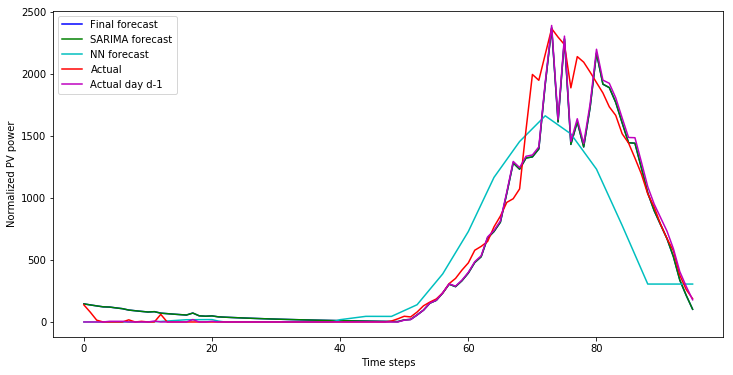

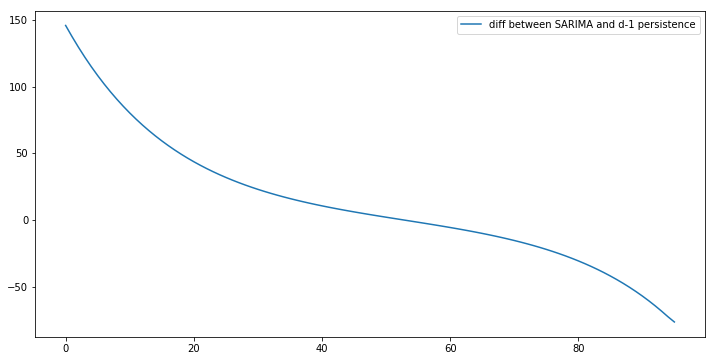

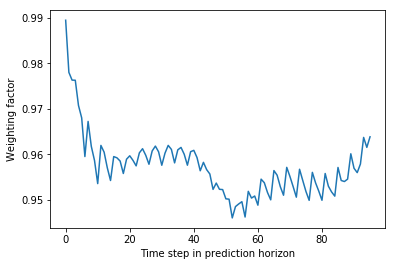

In [228]:
# Example how to get forecast
load_pv_data()

monthIdx = 8
dayIdx = 22 #12
hourIdx = 19

obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0)]
wf_df = wf_df.loc[wf_df.index>=datetime(2018,8,dayIdx,hourIdx,0,0)]

predHor = 96
timeStep = 15
timeStepCtrl = 5
tsPeriod = 96
retrainFlag = False
resample2CtrlStep = False
wfDf = wf_df.iloc[0]

PVforecast5min,PVforecast15min,PVforecastSARIMA,PVforecastNN = getPVforecast_betaVersion(obsDf,wfDf,models,predHor,
                                                                                         timeStep,timeStepCtrl,
                                                                                         tsPeriod,retrainFlag,resample2CtrlStep)
#print('PV forecast from SARIMA model: {}'.format(PVforecastSARIMA.transpose()))
#print('PV forecast from NN model: {}'.format(PVforecastNN.transpose()))
#print('Final PV forecast: {}'.format(PVforecast.transpose()))

PVactual = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx+1,hourIdx,0,0))]
PVactual_prevday = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx-1,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0))]
plt.plot(PVforecast15min,'-b',label='Final forecast')
plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
plt.plot(PVforecastNN,'-c',label='NN forecast')
plt.plot(PVactual.tolist(),'-r',label='Actual')
plt.plot(PVactual_prevday.tolist(),'-m',label='Actual day d-1')
plt.xlabel('Time steps')
plt.ylabel('Normalized PV power')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

prev_day = np.array(PVactual_prevday.tolist())
prev_day.shape=(PVforecastSARIMA.shape[0],1)
plt.plot(PVforecastSARIMA-prev_day,label='diff between SARIMA and d-1 persistence')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

plt.plot(models['alpha']['model'])
plt.xlabel('Time step in prediction horizon')
plt.ylabel('Weighting factor')
plt.show()

In [68]:
# loop prediction
PVforecastSARIMA_1step = []
obsDf = train
for i in range(96):
    print(i)
    if i>0:
        obsDf = obsDf.append(pd.DataFrame(data=([test.iloc[i]]),index=[obsDf.index[-1] + pd.Timedelta(minutes=timeStep)]))
    tmp1, tmp2, tmp3 = getPVforecast(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,wfDf,alpha)
    PVforecastSARIMA_1step = PVforecastSARIMA_1step + tmp2[0].tolist()
    print(PVforecastSARIMA_1step)

0
[0.0]
1
[0.0, 0.0]
2
[0.0, 0.0, 0.0]
3
[0.0, 0.0, 0.0, 0.0]
4
[0.0, 0.0, 0.0, 0.0, 0.0]
5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
9
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
11
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
12
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
13
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
14
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
15
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
16
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
17
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697]
46
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.536266546

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963]
59
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963, 0.4903963803863384, 0.4283054515584219, 0.3465918361140959, 0.2853631803955118, 0.27414830039192273, 0.2583979722318919, 0.2538101988891944, 0.23686276340076468, 0.18911442039392734, 0.16846765716287

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963, 0.4903963803863384, 0.4283054515584219, 0.3465918361140959, 0.2853631803955118, 0.27414830039192273, 0.2583979722318919, 0.2538101988891944, 0.23686276340076468, 0.18911442039392734, 0.16846765716287

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963, 0.4903963803863384, 0.4283054515584219, 0.3465918361140959, 0.2853631803955118, 0.27414830039192273, 0.2583979722318919, 0.2538101988891944, 0.23686276340076468, 0.18911442039392734, 0.16846765716287

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963, 0.4903963803863384, 0.4283054515584219, 0.3465918361140959, 0.2853631803955118, 0.27414830039192273, 0.2583979722318919, 0.2538101988891944, 0.23686276340076468, 0.18911442039392734, 0.16846765716287

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004752116553382745, 0.014935814088781528, 0.03211814656123217, 0.03345919877783725, 0.0517788038176067, 0.07904345139535934, 0.11490816816358103, 0.13403055281743328, 0.21477758737590402, 0.2443375505349434, 0.28411709486244774, 0.2847484944442015, 0.3647143602974533, 0.40764699631191215, 0.49497089795552296, 0.5362665462424673, 0.66432049156146, 0.6329050521206339, 0.6852703242623943, 0.6866147681135697, 0.7051592222230079, 0.7167214630072911, 0.7641994979007718, 0.7875328476131184, 0.7836293260095403, 0.7937136232106079, 0.7929276086144981, 0.7763490397968138, 0.7726921932389962, 0.7623472695126768, 0.7008443574664653, 0.681626126568004, 0.6052484860769963, 0.4903963803863384, 0.4283054515584219, 0.3465918361140959, 0.2853631803955118, 0.27414830039192273, 0.2583979722318919, 0.2538101988891944, 0.23686276340076468, 0.18911442039392734, 0.16846765716287

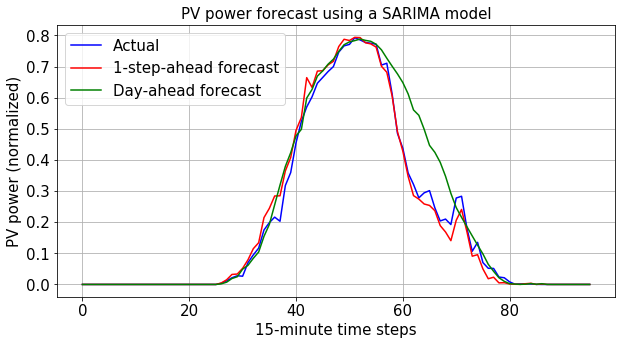

In [82]:
plt.plot(test.iloc[0:96].tolist(),'-b',label='Actual')
plt.plot(PVforecastSARIMA_1step,'-r',label='1-step-ahead forecast')
plt.plot(PVforecastSARIMA,'-g',label='Day-ahead forecast')
plt.title('PV power forecast using a SARIMA model',fontsize=15)
plt.xlabel('15-minute time steps',fontsize=15)
plt.ylabel('PV power (normalized)',fontsize=15)
plt.tick_params('x', labelsize=15)
plt.tick_params('y', labelsize=15)
plt.grid()
plt.legend(fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()


# Example on how to re-train models

In [192]:
# Example to show how to retrain combined model
filenameSARIMAnew = 'SARIMA_model_example.json'
filenameNNnew = 'NNmodel_best_example.sav'
filenameAlphaNew = 'optimal_weighting_factors_example'
hyperParams={'hidden_layer_sizes': [(50,50),(75,75)],
                                      'activation': ['relu','tanh'],
                                      'solver': ['lbfgs'],'learning_rate': ['constant'],'max_iter': [10000],
                                      'validation_fraction': [0.25]}
df_train = df_pv.loc[df_pv.index>=datetime(2018,8,29,0,0,0)]
wf_train = wf_df.loc[wf_df.index>=datetime(2018,8,29,0,0,0)]

retrainCombinedModel(models,df_train,wf_train,filenameSARIMAnew,filenameNNnew,filenameAlphaNew,0.5,hyperParams,96,15,96)

SARIMA training: done in 161.0 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NN training: done in 4.0 seconds
alpha training: done in 10.0 seconds


In [195]:
with open(filenameSARIMAnew, 'rb') as f:
    SARIMA_example = json.load(f)
SARIMAorder_example = np.array(SARIMA_example['order'])
SARIMAparams_example = np.array(SARIMA_example['params'])
print(SARIMA_example)

NN_example = joblib.load(filenameNNnew)
print(NN_example)

with open(filenameAlphaNew, 'rb') as f:
    alpha_example = json.load(f)
alpha_example = np.array(alpha_example['alpha'])
print(alpha_example.transpose())

{u'params': [0.827513729437672, -0.042361353172939625, -0.9371772157984661, 0.005778195973979187], u'order': [2, 0, 0, 0, 1, 1]}
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(75, 75), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.25,
       verbose=False, warm_start=False)
[[2.09504743e-05 2.18544652e-05 2.22132472e-05 3.02960218e-05
  2.43493045e-06 1.71927859e-06 1.07513414e-06 6.28091842e-07
  5.23593635e-07 9.10246816e-07 1.16797171e-06 1.07455600e-06
  1.03354097e-06 1.27923106e-06 1.11979938e-06 5.69569906e-07
  4.44974534e-07 5.36979613e-07 5.53125444e-07 4.73494644e-07
  4.08845253e-07 6.08687810e-07 9.66655466e-07 1.51296887e-06
  3.67120080e-06 5.87891187e-06 5.15224970e-06 3.01564080e-0

# Recycle Bin

In [ ]:
# Example to show how to retrain SARIMA model
filename1 = 'SARIMA_model_final.json'
filename2 = 'SARIMA_model_updated.json'
obsDf = df_pv

SARIMA_model_updated = retrainSARIMAmodel(obsDf,filename1,filename2)


In [221]:
# Train SARIMA without fixed order from previous training
filename = 'SARIMA_model_'+str(int(time.time()))+'.json'
startTime = time.time()

# train = df_pv
train = df_pv.loc[(df_pv.index>=datetime(2018,9,19))]

SARIMAorder = np.array([2, 0, 0, 0, 1, 1])
model = SARIMAX(train, order=(SARIMAorder[0], SARIMAorder[1], SARIMAorder[2]), 
                seasonal_order=(SARIMAorder[3], SARIMAorder[4], SARIMAorder[5], tsPeriod))#,enforce_stationarity=False)#,enforce_invertibility=False)
model_fit = model.fit(disp=1, method='lbfgs', maxiter=100)
SARIMAparams = model_fit.params
print('The new params are: {}'.format(SARIMAparams))

SARIMA_model_updated = {'order':SARIMAorder.tolist(), 'params':SARIMAparams.get_values().tolist()}
with open(filename, 'wb') as f:
    json.dump(SARIMA_model_updated, f)
    
optTime = time.time() - startTime
print('Total time (s): {}'.format(optTime))

The new params are: ar.L1       0.965495
ar.L2      -0.118385
ma.S.L96   -0.775182
sigma2      0.000084
dtype: float64
Total time (s): 885.051000118


In [11]:
# Example of retraining SARIMA with fixed order structure
filename = 'SARIMA_model_'+str(int(time.time()))+'.json'

startTime = time.time()

with open('SARIMA_model_updated_with_normalization.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order']) # fix the already identified optimal order structure
SARIMA_params_old = np.array(SARIMAres['params'])
print('The old params are: {}'.format(SARIMA_params_old))

train = df_pv
# train = df_pv.loc[(df_pv.index>=datetime.datetime(2018,8,26))]

model = SARIMAX(train, order=(SARIMAorder[0], SARIMAorder[1], SARIMAorder[2]), 
                seasonal_order=(SARIMAorder[3], SARIMAorder[4], SARIMAorder[5], tsPeriod))#,enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=1, method='lbfgs',start_params=SARIMA_params_old)
SARIMAparams = model_fit.params
print('The new params are: {}'.format(SARIMAparams))

SARIMA_model_updated = {'order':SARIMAorder.tolist(), 'params':SARIMAparams.get_values().tolist()}
with open(filename, 'wb') as f:
    json.dump(SARIMA_model_updated, f)
    
optTime = time.time() - startTime
print('Total time (s): {}'.format(optTime))

The old params are: [ 8.08340427e-01  1.36858886e-01 -9.07648358e-01  7.47276907e-04]


KeyboardInterrupt: 

In [65]:
with open('SARIMA_model_20180921.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])
print(SARIMAparams)
with open('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\Forecasting\old\data_and_results\second_tuning_version\SARIMA_model_updated_with_normalization.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])
print(SARIMAparams)


[ 7.91462898e-01  1.40358206e-01 -8.97486064e-01  1.17659814e+04]
[ 8.08340427e-01  1.36858886e-01 -9.07648358e-01  7.47276907e-04]


In [ ]:
## loop prediction
#PVforecastSARIMA_1step = []
#for i in range(96):
#    print(i)
#    obsDf = obsDf.append(test.iloc[0:i])
#    tmp1, tmp2, tmp3 = getPVforecast(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,wfDf,alpha)
#    PVforecastSARIMA_1step = PVforecastSARIMA_1step.append(tmp2[0])
#    print(PVforecastSARIMA_1step)
#

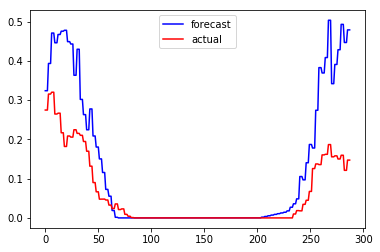

In [63]:
# plt.plot(PVforecastSARIMA,'-b',label='forecast')
# plt.plot(PVforecastNN,'-g',label='forecast')
# plt.plot(test.iloc[0:96].tolist(),'-r',label='actual')

plt.plot(PVforecast,'-b',label='forecast')
plt.plot(np.repeat(test.iloc[0:96].tolist(),3),'-r',label='actual')

plt.legend()
plt.show()

In [76]:
model_fit.summary()

fig, ax = plt.subplots()
plt.plot(train,label='actual')
plt.plot(model_fit.fittedvalues,'-r',label='forecast')
plt.title('1-step ahead forecast')
plt.ylabel('Normalized PV power')
plt.legend()
fig.set_size_inches(15,5)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
resSTD = np.std(residuals.values)
resMEAN = np.mean(residuals.values)

NameError: name 'model_fit' is not defined

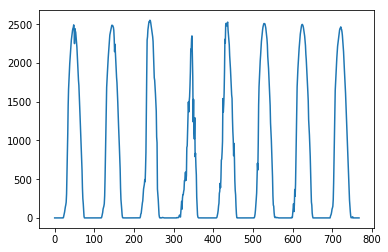

In [244]:
## Just to create an example obsDf dataframe series
## Load cleaned-up PV data
## df_pv = pd.read_pickle('PV_data_cleanedup')
#df_pv = pd.read_csv('PV_data_cleanedup.csv',index_col=[0])
#
## Further remove bad data by visual inspection
#dayIdxOut = []
#bad_days = [5, 29, 30]
#bad_ilocs = [288*(bd-1) for bd in bad_days]
#for bi in bad_ilocs:
#    dayIdxOut.append(df_pv['DayIndex'].iloc[bi])
#
#for i in range(len(dayIdxOut)):
#    df_pv = df_pv.loc[(df_pv['DayIndex']!=dayIdxOut[i])]
#
## Set index
#df_pv['date'] = pd.to_datetime(df_pv['date'])
#df_pv = df_pv.set_index('date')
#    
## Keep only data for April/May, because they are continuous
#i = 0
#while (df_pv.index[i].month<3) | (df_pv.index[i].month>6): 
#    i+=1
#df_pv = df_pv.iloc[i:]

useNewData = True

if (useNewData==False):
    # SECOND ROUND OF DATA 
    df_pv = pd.read_csv('PV_data_cleanedup_20180904.csv',index_col=[0])
    # Set index
    df_pv['date'] = pd.to_datetime(df_pv['date'])
    df_pv = df_pv.set_index('date')

    # Normalize data
    # df_pv = df_pv['totPower'] # use this if total PV power is of interest
    df_pv = df_pv['PV1_activePower_computed'] # use this if only inverter 1 PV power is of interest
    normalizeData = False
    if normalizeData:
        df_pv_nom = np.amax(df_pv)
        df_pv = df_pv/np.abs(df_pv_nom)

    # if 5min time step is used, seasonal period is 288 steps (1 day)
    # tsPeriod = 288 
    df_pv = df_pv.resample('15T').mean()
    # df_pv = df_pv.dropna()
    tsPeriod = 96
else:
    # Load data collected in September
    df_pv = pd.read_csv('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data.csv',index_col=[0])
    df_pv.index = pd.to_datetime(df_pv.index)
    df_pv = df_pv.resample('15T').mean()
    # df_pv = df_pv.dropna()
    tsPeriod = 96
    df_pv = df_pv['DC_PV_W']
    normalizeData = False
    if normalizeData:
        df_pv_nom = np.amax(df_pv)
        df_pv = df_pv/np.abs(df_pv_nom)
    # print(df_pv)
    #df_pv = df_pv.dropna()
    plt.plot(df_pv.iloc[0:96*4*2].tolist())
    plt.show()
    
# Weather data
# wf_df = pd.read_pickle('weather_forecast_dataframe')
wf_df = pd.read_json('weather_forecast_dataframe_updated.json')
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

In [ ]:
# Example how to get forecast
#print(wf_df.index[0])
#print(df_pv.index[0])

monthIdx = 9
dayIdx = 12
hourIdx = 14

obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0)]
wf_df = wf_df.loc[wf_df.index>=datetime(2018,8,dayIdx,hourIdx,0,0)]

#data = np.load('SARIMA_best_models_15_min.npz')
#SARIMAorder = data['listOfOrders'][0]
#print(SARIMAorder)
#SARIMAparams = data['listOfParams'][0]

# SARIMAres = np.load('SARIMA_model_final_v2.npz')
# SARIMAorder = SARIMAres['order']
# SARIMAparams = SARIMAres['params']

# with open('SARIMA_model_20180921.json', 'rb') as f:
# with open('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\Forecasting\old\data_and_results\second_tuning_version\SARIMA_model_updated_with_normalization.json', 'rb') as f:
with open('SARIMA_model_multiple_steps_20180926.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])

# modelsAll = pickle.load(open('NNmodel_updated.sav', 'rb'))
#modelsAll = joblib.load('NNmodel_20180921.sav')
#NNmodel = modelsAll.best_estimator_
NNmodel = joblib.load('NNmodel_best_20180927_normalize_input_outofsample.sav')
predHor = 96
timeStep = 15
timeStepCtrl = 5
tsPeriod = 96
retrainFlag = False
resample2CtrlStep = False
wfDf = wf_df.iloc[0]
# alpha = np.ones(96) 
#with open('optimal_weighting_factors_updated.json') as f:
with open('optimal_weighting_factors_20180921.json') as f:
    tmp = json.load(f)
alpha = 0*np.array(tmp['alpha'])
    
normalizeData = True
PVforecast5min, PVforecast15min, PVforecastSARIMA, PVforecastNN = getPVforecast_v1(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,normalizeData,wfDf,alpha,resample2CtrlStep)
#print('PV forecast from SARIMA model: {}'.format(PVforecastSARIMA.transpose()))
#print('PV forecast from NN model: {}'.format(PVforecastNN.transpose()))
#print('Final PV forecast: {}'.format(PVforecast.transpose()))

PVactual = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx+1,hourIdx,0,0))]
PVactual_prevday = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx-1,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0))]
plt.plot(PVforecast15min,'-b',label='Final forecast')
plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
plt.plot(PVforecastNN,'-c',label='NN forecast')
plt.plot(PVactual.tolist(),'-r',label='Actual')
plt.plot(PVactual_prevday.tolist(),'-m',label='Actual day d-1')
plt.xlabel('Time steps')
plt.ylabel('Normalized PV power')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

prev_day = np.array(PVactual_prevday.tolist())
prev_day.shape=(PVforecastSARIMA.shape[0],1)
plt.plot(PVforecastSARIMA-prev_day,label='diff between SARIMA and d-1 persistence')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()


In [174]:
# Alpha
models['alpha'] = {}
models['alpha']['loaded'] = True
models['alpha']['path'] = 'optimal_weighting_factors_MOSEK_1538179073.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha']['model'] = np.array(alphaRes['alpha'])

models['alpha2'] = {}
models['alpha2']['loaded'] = True
models['alpha2']['path'] = 'optimal_weighting_factors_ECOS_1538179073.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha2']['model'] = np.array(alphaRes['alpha'])

np.amax(models['alpha']['model']-models['alpha2']['model'])

0.0